In [1]:
import utils
import itertools
import logging
import psutil

/home/ricky/miniconda3/envs/pop/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.os.makedirs("logs", exist_ok=True)
logging.basicConfig(
    filename="logs/umap_hdbscan_runs.log",
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)

def log_resource(stage, run_id=None):
    """Log current RAM usage (GB)"""
    process = psutil.Process(utils.os.getpid())
    mem_gb = process.memory_info().rss / 1e9
    logging.info(f"Run {run_id} | {stage} | RAM: {mem_gb:.2f} GB")
    print(f"[Run {run_id}] {stage}: RAM {mem_gb:.2f} GB")
    return mem_gb

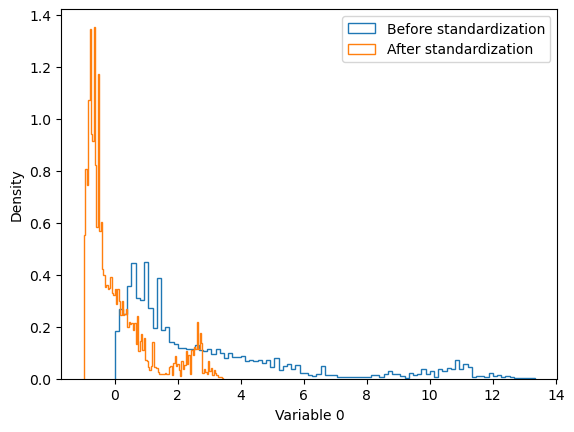

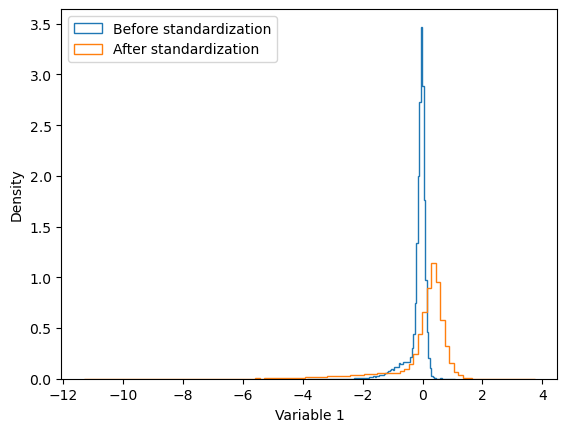

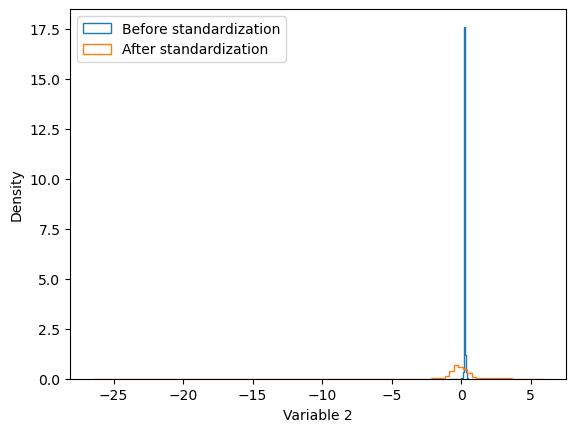

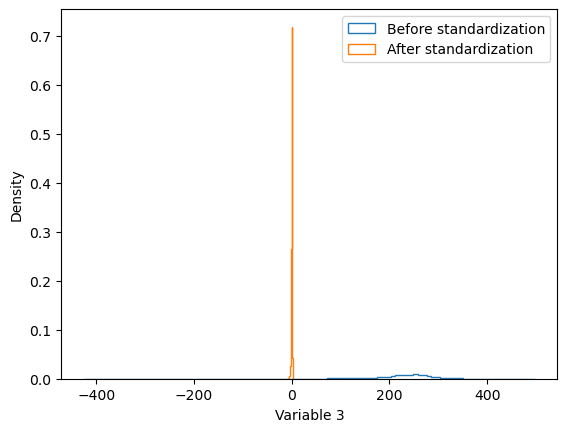

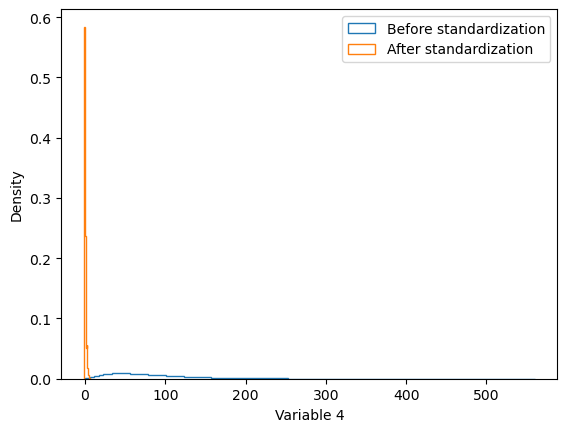

In [3]:
data = utils.pd.read_csv('Ricardo Full Samples/sample_A_m12f-lsr0.csv')
interest = ['age','feh','alpha','V','UW']
data = data[['age','feh','alpha','V','UW']]

# It is good practice to standardize the data
# There are many different types of standardization
X = utils.StandardScaler().fit_transform(data).astype(utils.np.float32)

hist_kwargs = {
    'histtype' : 'step',
    'bins'     : 100,
    'density'  : True
}


for i in range(data.shape[1]):
    utils.plt.hist(
        data.values[:, i],
        label = 'Before standardization',
        **hist_kwargs
    )

    utils.plt.hist(
        X[:, i],
        label = 'After standardization',
        **hist_kwargs
    )

    utils.plt.xlabel(f'Variable {i}')
    utils.plt.ylabel('Density')
    utils.plt.legend(loc='best')

    utils.plt.show()

In [4]:
umap_param_grid = {
    "n_neighbors": utils.np.linspace(10,55,num=10),
    "min_dist": utils.np.linspace(0.0,0.9,num=10),
    "n_epochs": [1000],
    "verbose": [True],
    "set_op_mix_ratio": utils.np.linspace(0.0,0.9,num=10),
    "local_connectivity": utils.np.linspace(1,5,num=10)
}

combinations = list(itertools.product(
    umap_param_grid["n_neighbors"],
    umap_param_grid["min_dist"],
    umap_param_grid["n_epochs"],
    umap_param_grid["verbose"],
    umap_param_grid["set_op_mix_ratio"],
    umap_param_grid["local_connectivity"]
))
logging.info(f"Total combinations: {len(combinations)}")

2025-11-18 12:05:55,663 [INFO] Total combinations: 10000


In [5]:
def run_umap_on_core(args):
    """Run a single UMAP embedding pinned to a specific CPU core."""
    idx, (n_neighbors,min_dist,n_epochs,verbose,set_op_mix_ratio,local_connectivity) = args
    core_id = idx % utils.os.cpu_count()  # assign one core per process
    run_id = f"UMAP_{idx:02d}_core{core_id}_n{n_neighbors}_d{min_dist}_e{n_epochs}"

    try:
        # Pin process to one CPU core
        utils.os.sched_setaffinity(0, {core_id})
        print(f"\n[{run_id}] Starting on CPU core {core_id}")
        logging.info(f"[{run_id}] Starting on core {core_id}")

        log_resource("Before UMAP", run_id)
        utils.wrapper(idx, X, n_neighbors, min_dist, n_epochs, verbose, set_op_mix_ratio, local_connectivity)
        log_resource("After UMAP", run_id)

        logging.info(f"[{run_id}] Completed successfully")
        print(f"[{run_id}] Completed")

    except Exception as e:
        logging.error(f"[{run_id}] Failed: {e}")
        print(f"[{run_id}] Failed: {e}")

In [6]:
print("Running UMAPs in parallel (1 process per core)")
available_cores = utils.os.cpu_count()
processes = min(len(combinations), available_cores)
logging.info(f"Using {processes} parallel processes (one per core).")

with utils.mp.Pool(processes=processes) as pool:
    pool.map(run_umap_on_core, enumerate(combinations))

print("All UMAP embeddings generated.")
logging.info("All UMAP embeddings completed.")

2025-11-18 12:06:19,808 [INFO] Using 8 parallel processes (one per core).


Running UMAPs in parallel (1 process per core)

[UMAP_939_core3_n10.0_d0.9_e1000] Starting on CPU core 3
[UMAP_00_core0_n10.0_d0.0_e1000] Starting on CPU core 0
[UMAP_626_core2_n10.0_d0.6000000000000001_e1000] Starting on CPU core 2
[UMAP_1252_core4_n15.0_d0.2_e1000] Starting on CPU core 4

[UMAP_313_core1_n10.0_d0.30000000000000004_e1000] Starting on CPU core 1
[UMAP_1565_core5_n15.0_d0.5_e1000] Starting on CPU core 5

[UMAP_1878_core6_n15.0_d0.8_e1000] Starting on CPU core 6





2025-11-18 12:06:19,873 [INFO] [UMAP_626_core2_n10.0_d0.6000000000000001_e1000] Starting on core 2


2025-11-18 12:06:19,873 [INFO] [UMAP_1252_core4_n15.0_d0.2_e1000] Starting on core 4
2025-11-18 12:06:19,874 [INFO] [UMAP_313_core1_n10.0_d0.30000000000000004_e1000] Starting on core 1
2025-11-18 12:06:19,874 [INFO] [UMAP_1565_core5_n15.0_d0.5_e1000] Starting on core 5
2025-11-18 12:06:19,874 [INFO] [UMAP_00_core0_n10.0_d0.0_e1000] Starting on core 0
2025-11-18 12:06:19,876 [INFO] Run UMAP_626_core2_n10.0_d0.6000000000000001_e1000 | Before UMAP | RAM: 0.25 GB



[UMAP_2191_core7_n20.0_d0.1_e1000] Starting on CPU core 7

2025-11-18 12:06:19,876 [INFO] Run UMAP_1252_core4_n15.0_d0.2_e1000 | Before UMAP | RAM: 0.25 GB
2025-11-18 12:06:19,876 [INFO] Run UMAP_1565_core5_n15.0_d0.5_e1000 | Before UMAP | RAM: 0.25 GB
2025-11-18 12:06:19,875 [INFO] [UMAP_1878_core6_n15.0_d0.8_e1000] Starting on core 6
2025-11-18 12:06:19,876 [INFO] Run UMAP_313_core1_n10.0_d0.30000000000000004_e1000 | Before UMAP | RAM: 0.25 GB
2025-11-18 12:06:19,877 [INFO] Run UMAP_00_core0_n10.0_d0.0_e1000 | Before UMAP | RAM: 0.25 GB


[Run UMAP_626_core2_n10.0_d0.6000000000000001_e1000] Before UMAP: RAM 0.25 GB[Run UMAP_1252_core4_n15.0_d0.2_e1000] Before UMAP: RAM 0.25 GB

2025-11-18 12:06:19,872 [INFO] [UMAP_939_core3_n10.0_d0.9_e1000] Starting on core 3


[Run UMAP_1565_core5_n15.0_d0.5_e1000] Before UMAP: RAM 0.25 GB[Run UMAP_313_core1_n10.0_d0.30000000000000004_e1000] Before UMAP: RAM 0.25 GB


2025-11-18 12:06:19,878 [INFO] Run UMAP_1878_core6_n15.0_d0.8_e1000 | Before UMAP | RAM: 0.25 GB


2025-11-18 12:06:19,881 [INFO] Run UMAP_939_core3_n10.0_d0.9_e1000 | Before UMAP | RAM: 0.25 GB



[Run UMAP_00_core0_n10.0_d0.0_e1000] Before UMAP: RAM 0.25 GB[Run UMAP_1878_core6_n15.0_d0.8_e1000] Before UMAP: RAM 0.25 GB

2025-11-18 12:06:19,882 [INFO] [Wrapper 1252] pinned to core 4
2025-11-18 12:06:19,883 [INFO] [Wrapper 1565] pinned to core 5
2025-11-18 12:06:19,883 [INFO] [Wrapper 313] pinned to core 1


2025-11-18 12:06:19,884 [INFO] [UMAP 1565] running with params: {'n_neighbors': 15, 'min_dist': 0.5, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.6000000000000001, 'local_connectivity': 3.2222222222222223}
2025-11-18 12:06:19,881 [INFO] [UMAP_2191_core7_n20.0_d0.1_e1000] Starting on core 7


[Run UMAP_939_core3_n10.0_d0.9_e1000] Before UMAP: RAM 0.25 GB

2025-11-18 12:06:19,884 [INFO] [UMAP 1252] running with params: {'n_neighbors': 15, 'min_dist': 0.2, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.5, 'local_connectivity': 1.8888888888888888}
2025-11-18 12:06:19,882 [INFO] [Wrapper 626] pinned to core 2
2025-11-18 12:06:19,887 [INFO] [Wrapper 1878] pinned to core 6
2025-11-18 12:06:19,888 [INFO] Run UMAP_2191_core7_n20.0_d0.1_e1000 | Before UMAP | RAM: 0.25 GB
2025-11-18 12:06:19,889 [INFO] [UMAP 626] running with params: {'n_neighbors': 10, 'min_dist': 0.6000000000000001, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.2, 'local_connectivity': 3.6666666666666665}
2025-11-18 12:06:19,885 [INFO] [UMAP 313] running with params: {'n_neighbors': 10, 'min_dist': 0.30000000000000004, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.1, 'local_connectivity': 2.333333333333333}


2025-11-18 12:06:19,888 [INFO] [Wrapper 0] pinned to core 0
2025-11-18 12:06:19,890 [INFO] [UMAP 1878] running with params: {'n_neighbors': 15, 'min_dist': 0.8, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.7000000000000001, 'local_connectivity': 4.555555555555555}
2025-11-18 12:06:19,891 [INFO] [Wrapper 939] pinned to core 3
2025-11-18 12:06:19,891 [INFO] [UMAP 0] running with params: {'n_neighbors': 10, 'min_dist': 0.0, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.0, 'local_connectivity': 1.0}


[Run UMAP_2191_core7_n20.0_d0.1_e1000] Before UMAP: RAM 0.25 GB


2025-11-18 12:06:19,895 [INFO] [UMAP 939] running with params: {'n_neighbors': 10, 'min_dist': 0.9, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.30000000000000004, 'local_connectivity': 5.0}


UMAP(local_connectivity=3.2222222222222223, min_dist=0.5, n_epochs=1000, set_op_mix_ratio=0.6000000000000001, verbose=True)
UMAP(local_connectivity=4.555555555555555, min_dist=0.8, n_epochs=1000, set_op_mix_ratio=0.7000000000000001, verbose=True)

2025-11-18 12:06:19,900 [INFO] [Wrapper 2191] pinned to core 7



UMAP(min_dist=0.0, n_epochs=1000, n_neighbors=10, set_op_mix_ratio=0.0, verbose=True)

2025-11-18 12:06:19,906 [INFO] [UMAP 2191] running with params: {'n_neighbors': 20, 'min_dist': 0.1, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.9, 'local_connectivity': 1.4444444444444444}



UMAP(local_connectivity=2.333333333333333, min_dist=0.30000000000000004, n_epochs=1000, n_neighbors=10, set_op_mix_ratio=0.1, verbose=True)
UMAP(local_connectivity=3.6666666666666665, min_dist=0.6000000000000001, n_epochs=1000, n_neighbors=10, set_op_mix_ratio=0.2, verbose=True)UMAP(local_connectivity=1.8888888888888888, min_dist=0.2, n_epochs=1000, set_op_mix_ratio=0.5, verbose=True)

UMAP(local_connectivity=1.4444444444444444, n_epochs=1000, n_neighbors=20, set_op_mix_ratio=0.9, verbose=True)UMAP(local_connectivity=5.0, min_dist=0.9, n_epochs=1000, n_neighbors=10, set_op_mix_ratio=0.30000000000000004, verbose=True)

Tue Nov 18 12:06:19 2025Tue Nov 18 12:06:19 2025  Construct fuzzy simplicial setConstruct fuzzy simplicial set

Tue Nov 18 12:06:19 2025 Construct fuzzy simplicial set
Tue Nov 18 12:06:19 2025 Construct fuzzy simplicial set
Tue Nov 18 12:06:19 2025Finding Nearest Neighbors Tue Nov 18 12:06:19 2025Tue Nov 18 12:06:19 2025 Finding Nearest Neighbors
 
Construct fuzzy simpli

/home/ricky/miniconda3/envs/pop/lib/python3.8/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = inf has removed 0 edges.
It has only fully disconnected 443 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Tue Nov 18 12:09:23 2025 Construct embedding
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Tue Nov 18 12:09:29 2025 Finished Nearest Neighbor Search
Tue Nov 18 12:09:41 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs


Epochs completed:   3%| ▎          28/1000 [00:30]

	completed  0  /  1000 epochs


Epochs completed:   6%| ▌          59/1000 [00:58]

	completed  0  /  1000 epochs


Epochs completed:   1%|            8/1000 [00:10]]

	completed  0  /  1000 epochs


Epochs completed:   5%| ▍          48/1000 [00:38]]

	completed  100  /  1000 epochs


Epochs completed:   6%| ▌          62/1000 [00:45]]

	completed  100  /  1000 epochs


Epochs completed:  13%| █▎         126/1000 [01:59]

	completed  

Epochs completed:  10%| ▉          99/1000 [01:09]

100

Epochs completed:  15%| █▌         152/1000 [01:41]

  /  1000 

Epochs completed:  13%| █▎         127/1000 [02:00]

epochs


Epochs completed:  10%| █          102/1000 [01:08]

	completed  100

Epochs completed:  15%| █▌         154/1000 [01:42]

  /  1000 epochs


Epochs completed:  15%| █▌         152/1000 [01:39]

	completed  200  /  1000

Epochs completed:  15%| █▌         153/1000 [01:38]

 epochs

Epochs completed:  16%| █▌         160/1000 [02:31]

Epochs completed:  20%| █▉         196/1000 [02:09]

	completed  200  /  1000 epochs


Epochs completed:  21%| ██         207/1000 [02:11]

	completed  200  /  1000 epochs


Epochs completed:  26%| ██▋        265/1000 [02:53]

	completed  200  /  1000 epochs


Epochs completed:  26%| ██▌        257/1000 [02:41]

	completed  300  /  1000 epochs


Epochs completed:  30%| ███        300/1000 [03:08]

	completed  0  /  1000 epochs

Epochs completed:  29%| ██▉        292/1000 [03:10]

Epochs completed:   0%|            2/1000 [00:10]1]

	completed  300  /  1000 epochs


Epochs completed:   2%| ▏          23/1000 [00:16]]

	completed  300  / 

Epochs completed:  35%| ███▌       354/1000 [03:49]

 1000 epochs


Epochs completed:  36%| ███▌       355/1000 [03:41]

	completed  100  /  1000 epochs


Epochs completed:  36%| ███▌       357/1000 [03:42]

	completed  400  /  1000 epochs

Epochs completed:  11%| █          106/1000 [00:43]

Epochs completed:  36%| ███▋       364/1000 [03:56]

	completed  300  /  1000 epochs


Epochs completed:  18%| █▊         179/1000 [01:09]

	completed  400  /  1000 epochs


Epochs completed:  42%| ████▏      415/1000 [04:17]

	completed  200  /  

Epochs completed:  45%| ████▌      454/1000 [04:51]

1000 epochs


Epochs completed:  42%| ████▏      417/1000 [04:18]

	completed  

Epochs completed:  20%| ██         204/1000 [01:19]

400  /  1000

Epochs completed:  32%| ███▎       325/1000 [05:11]

Epochs completed:  46%| ████▌      456/1000 [04:52]

epochs


Epochs completed:  28%| ██▊        282/1000 [01:46]

	completed  500  / 

Epochs completed:  28%| ██▊        283/1000 [01:47]

 1000 

Epochs completed:  50%| █████      501/1000 [05:20]

epochs


Epochs completed:  51%| █████      511/1000 [05:26]

	completed  300  /  1000 epochs


Epochs completed:  48%| ████▊      485/1000 [05:12]

	completed  

Epochs completed:  36%| ███▌       359/1000 [02:12]

500  / 

Epochs completed:  54%| █████▍     542/1000 [05:45]

 1000 epochs


Epochs completed:  39%| ███▉       389/1000 [06:13]

	completed 

Epochs completed:  39%| ███▊       386/1000 [02:21]

 500  /  1000 epochs


Epochs completed:  51%| █████      509/1000 [05:27]

	completed  400  / 

Epochs completed:  39%| ███▉       394/1000 [06:18]

 1000 epochs


Epochs completed:  42%| ████▏      420/1000 [02:33]

	completed  400  /  1000 epochs


Epochs completed:  54%| █████▍     543/1000 [05:49]

	completed  600  /  

Epochs completed:  47%| ████▋      466/1000 [02:49]

1000 epochs


Epochs completed:  58%| █████▊     584/1000 [06:07]

	completed  500  /  

Epochs completed:  57%| █████▋     566/1000 [06:09]

1000 epochs


Epochs completed:  44%| ████▍      443/1000 [07:11]

	completed 

Epochs completed:  64%| ██████▍    640/1000 [06:52]

 600  /  1000

Epochs completed:  53%| █████▎     532/1000 [03:20]

 epochs


Epochs completed:  57%| █████▋     568/1000 [03:33]

	completed  600  /  1000 epochs

Epochs completed:  46%| ████▌      456/1000 [07:25]

Epochs completed:  62%| ██████▏    617/1000 [06:45]

	completed  600  /  1000 epochs


Epochs completed:  63%| ██████▎    630/1000 [03:54]

	completed  0  / 
 1000 epochs

Epochs completed:  64%| ██████▍    639/1000 [03:57]

	completed  700 

Epochs completed:  64%| ██████▎    637/1000 [06:58]

 /  1000 epochs


Epochs completed:  70%| ██████▉    697/1000 [04:18]

	completed  500  /  1000 epochs

Epochs completed:   4%| ▎          36/1000 [00:30]]

Epochs completed:  70%| ███████    700/1000 [04:19]

	completed  700  /  1000 epochs


Epochs completed:   4%| ▍          42/1000 [00:34]]

	completed  700  /  1000 epochs


Epochs completed:  73%| ███████▎   732/1000 [07:39]

	completed  

Epochs completed:  76%| ███████▌   761/1000 [04:41]

700  /  

Epochs completed:  76%| ███████▋   764/1000 [08:13]

1000 epochs


Epochs completed:  80%| ████████   800/1000 [04:54]

	completed  800 

Epochs completed:  78%| ███████▊   782/1000 [08:27]

 /  1000 epochs


Epochs completed:  83%| ████████▎  833/1000 [05:06]

	completed 

Epochs completed:  80%| ███████▉   798/1000 [08:39]

 100

Epochs completed:  74%| ███████▎   736/1000 [08:07]

  /  1000 epochs


Epochs completed:  55%| █████▍     548/1000 [09:00]

	completed 

Epochs completed:  10%| █          103/1000 [01:19]

 800  /  1000 epochs


Epochs completed:  83%| ████████▎  827/1000 [08:57]

	completed 

Epochs completed:  56%| █████▋     565/1000 [09:17]

 800  /  

Epochs completed:  89%| ████████▉  888/1000 [05:25]

1000 epochs


Epochs completed:  77%| ███████▋   771/1000 [08:30]

	completed  900  /  1000 epochs


Epochs completed:  86%| ████████▋  864/1000 [09:22]

	completed  800  /  

Epochs completed:  96%| █████████▌ 956/1000 [05:49]

1000 epochs

Epochs completed:  16%| █▋         165/1000 [02:01]

Epochs completed:  99%| █████████▉ 989/1000 [06:01]

	completed  

Epochs completed:  18%| █▊         182/1000 [02:13]

600  /  1000 epochs

Epochs completed:  99%| █████████▉ 990/1000 [06:02]

Epochs completed: 100%| ██████████ 1000/1000 [06:06]
Epochs completed:  19%| █▊         187/1000 [02:17]

Tue Nov 18 12:20:41 2025 Finished embedding


Epochs completed:  19%| █▉         194/1000 [02:23]2025-11-18 12:20:47,199 [INFO] [UMAP 313] saved umap_outputs/umap_embeddings_313.csv and umap_outputs/umap_scatter_313.png
Epochs completed:  83%| ████████▎  833/1000 [09:13]2025-11-18 12:20:47,988 [INFO] Run UMAP_313_core1_n10.0_d0.30000000000000004_e1000 | After UMAP | RAM: 0.71 GB


[Run UMAP_313_core1_n10.0_d0.30000000000000004_e1000] After UMAP: RAM 0.71 GB


2025-11-18 12:20:48,007 [INFO] [UMAP_313_core1_n10.0_d0.30000000000000004_e1000] Completed successfully


[UMAP_313_core1_n10.0_d0.30000000000000004_e1000] Completed

[UMAP_314_core2_n10.0_d0.30000000000000004_e1000] Starting on CPU core 2


2025-11-18 12:20:48,084 [INFO] [UMAP_314_core2_n10.0_d0.30000000000000004_e1000] Starting on core 2
2025-11-18 12:20:48,125 [INFO] Run UMAP_314_core2_n10.0_d0.30000000000000004_e1000 | Before UMAP | RAM: 0.71 GB
Epochs completed:  83%| ████████▎  834/1000 [09:13]

[Run UMAP_314_core2_n10.0_d0.30000000000000004_e1000] Before UMAP: RAM 0.71 GB

Epochs completed:  88%| ████████▊  878/1000 [09:12]

2025-11-18 12:20:48,229 [INFO] [Wrapper 314] pinned to core 2
2025-11-18 12:20:48,260 [INFO] [UMAP 314] running with params: {'n_neighbors': 10, 'min_dist': 0.30000000000000004, 'n_epochs': 1000, 'verbose': True, 'set_op_mix_ratio': 0.1, 'local_connectivity': 2.7777777777777777}
Epochs completed:  90%| ████████▉  899/1000 [09:46]

UMAP(local_connectivity=2.7777777777777777, min_dist=0.30000000000000004, n_epochs=1000, n_neighbors=10, set_op_mix_ratio=0.1, verbose=True)


Epochs completed:  20%| █▉         196/1000 [02:25]

Tue Nov 18 12:20:48 2025 Construct fuzzy simplicial set


Epochs completed:  20%| █▉         197/1000 [02:25]

Tue Nov 18 12:20:49 2025 Finding Nearest Neighbors
Tue Nov 18 12:20:49 2025 Building RP forest with 19 

Epochs completed:  84%| ████████▎  836/1000 [09:15]

trees


Epochs completed:  88%| ████████▊  880/1000 [09:13]

	completed  900  /  1000 epochs


Epochs completed:  88%| ████████▊  884/1000 [09:16]

	completed  200  / 

Epochs completed:  62%| ██████▏    615/1000 [10:09]

 1000 epochs


Epochs completed:  20%| ██         202/1000 [02:29]

KeyboardInterrupt: 

In [ ]:

for i in range(utils.mp.cpu_count()):
    d = utils.pd.read_csv(f'umap_embeddings_{i}.csv')
    utils.opt(d, trials = 100)
    data_copy = data.copy()
    data_copy['labels'] = labels
    utils.concat[data_copy,d,axis==1].to_csv(f'results_{i}', index=False)

## save all embedding info
## check ram and cores -> then open new process